# Dynamic Replica dataset

In [1]:
import gzip
import os.path as osp
import torch
import numpy as np
import flow_vis
import matplotlib.pyplot as plt

from typing import List, Optional
from dataclasses import dataclass
from PIL import Image

from pytorch3d.implicitron.dataset.types import (
    FrameAnnotation as ImplicitronFrameAnnotation,
    load_dataclass
)

## Annotations
If you don't need some of these annotations, you can just remove them from **DynamicReplicaFrameAnnotation**


In [2]:
@dataclass
class DynamicReplicaFrameAnnotation(ImplicitronFrameAnnotation):
    """A dataclass used to load annotations from .json"""
    camera_name: Optional[str] = None
    instance_id_map_path: Optional[str] = None
    flow_forward: Optional[str] = None
    flow_forward_mask: Optional[str] = None
    flow_backward: Optional[str] = None
    flow_backward_mask: Optional[str] = None
    trajectories: Optional[str] = None

We load paths to all the annotation files from a .jgz file. 

**frame_annots_list** contains all the frames of the corresponding dataset split (train / valid / test).

In [6]:
root = '../dynamic_replica_data_2/'
split = 'valid'
frame_annotations_file = f'frame_annotations_{split}.jgz'
with gzip.open(osp.join(root, split, frame_annotations_file), "rt", encoding="utf8") as zipfile:
    frame_annots_list = load_dataclass(
                zipfile, List[DynamicReplicaFrameAnnotation]
            )

Each sequence in 'valid' split contains 300 frames for each view (left and right). 
So, a new sequence starts every 600 frames:

In [7]:
for i in [0,300,600]:
    print('Sequence name:', frame_annots_list[i].sequence_name)
    print('Sequence frame number:', frame_annots_list[i].frame_number)
    print('Sequence frame timestamp:', frame_annots_list[i].frame_timestamp)
    print('View:', frame_annots_list[i].camera_name)


Sequence name: e0ff8f-3_obj
Sequence frame number: 0
Sequence frame timestamp: 0.0
View: left
Sequence name: e0ff8f-3_obj
Sequence frame number: 0
Sequence frame timestamp: 0.0
View: right
Sequence name: ff80e8-3_obj
Sequence frame number: 0
Sequence frame timestamp: 0.0
View: left


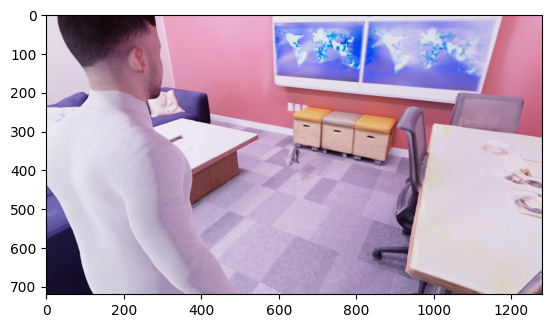

In [8]:
im_path = osp.join(root, split, frame_annots_list[100].image.path)
plt.imshow(Image.open(im_path))

## Optical flow
Forward flow is defined for all the sequence frames except the last one. Backward flow is defined for all the frames except the first one.

In [9]:
def flowreader(flow_path):
    with Image.open(flow_path) as depth_pil:
        # the image is stored with 16-bit depth but PIL reads it as I (32 bit).
        # we cast it to uint16, then reinterpret as float16, then cast to float32
        flow = np.frombuffer(
            np.array(depth_pil, dtype=np.uint16), dtype=np.float16
        ).astype(np.float32).reshape((depth_pil.size[1], depth_pil.size[0]))
    flow_res = np.stack([flow[:,:flow.shape[1]//2], flow[:,flow.shape[1]//2:]],axis=-1)
    return flow_res

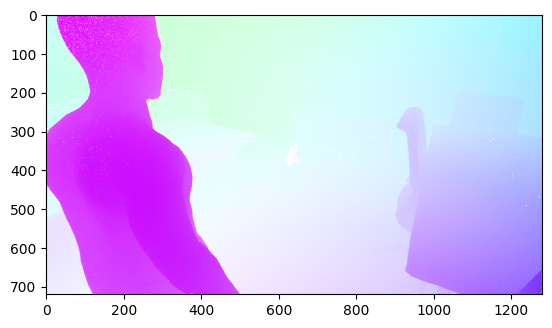

In [10]:
flow_path = osp.join(root, split, frame_annots_list[100].flow_forward['path'])
flow_mask_path = osp.join(root, split, frame_annots_list[100].flow_forward_mask['path'])

flow_forward = flowreader(flow_path)
flow_forward_mask = np.array(Image.open(flow_mask_path))

plt.imshow(flow_vis.flow_to_color(flow_forward*flow_forward_mask[:,:,None], convert_to_bgr=False))

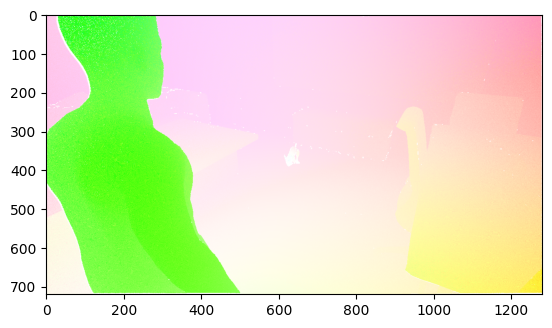

In [11]:
flow_path = osp.join(root, split, frame_annots_list[101].flow_backward['path'])
flow_mask_path = osp.join(root, split, frame_annots_list[101].flow_backward_mask['path'])

flow_backward = flowreader(flow_path)
flow_backward_mask = np.array(Image.open(flow_mask_path))

plt.imshow(flow_vis.flow_to_color(flow_backward*flow_backward_mask[:,:,None], convert_to_bgr=False))

## Long-range trajectories

Trajectories are coordinates of all the mesh vertices visible at least in one frame of the sequence.
They are defined only for the *left view*. 

We provide global 3D coordinates and 2D coordinates in image space as well as binary visibility flags for the current frame.

In [12]:
print('These are 2D coordinates and visibility flags of the same vertices for frames 50 and 100:')
for i in [50,100]:
    traj_path = osp.join(root, split, frame_annots_list[i].trajectories['path'])
    traj = torch.load(traj_path)

    print(f"Frame {i}: traj shape", traj["traj_2d"].shape) # 2d coords
    print(f"Frame {i}: visibility shape", traj["verts_inds_vis"].shape) # visibility flags

These are 2D coordinates and visibility flags of the same vertices for frames 50 and 100:
Frame 50: traj shape torch.Size([23246, 3])
Frame 50: visibility shape torch.Size([23246])
Frame 100: traj shape torch.Size([23246, 3])
Frame 100: visibility shape torch.Size([23246])


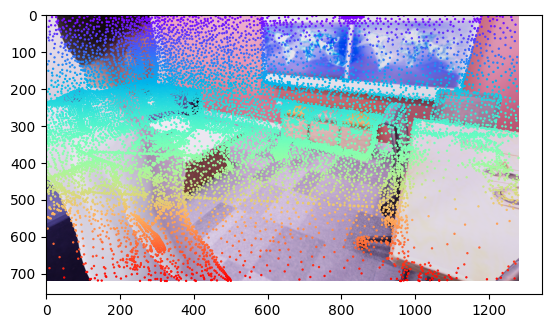

In [13]:
# Visualized trajectories fro one frame:
h, w = frame_annots_list[0].image.size

x_coords, y_coords = traj["traj_2d"][:,0], traj["traj_2d"][:,1]
y_min, y_max = 0, h

rainbow = plt.get_cmap('rainbow')

# normalize the y-coordinates to be between 0 and 1
norm = plt.Normalize(y_min, y_max)

# filter out outliers
mask = torch.logical_and(torch.logical_and(x_coords>0, x_coords<w), torch.logical_and(y_coords>0, y_coords<h))
x_coords=x_coords[mask]
y_coords=y_coords[mask]

plt.imshow(Image.open(im_path))
plt.scatter(x=x_coords, y=y_coords, s=0.5, c=y_coords, cmap=rainbow, norm=norm)